## instalaciones

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3

In [ ]:
import pandas as pd
import numpy as np

# MODELO DEFINITIVO SIN FOTOS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta Laura

df = pd.read_csv('/content/drive/MyDrive/TFM/csv/datos_preprocesados.csv')


In [ ]:
# Ruta Ángel

#df = pd.read_csv('/content/drive/MyDrive/CEU SAN PABLO/TFM/datos.csv')


# Ruta con metro

df = pd.read_csv('/content/drive/MyDrive/CEU SAN PABLO/TFM/datos_plus.csv')

# 1. Visualizaciones

In [ ]:

# Asegúrate de que df_final es el DataFrame que estás utilizando
# y que contiene las columnas 'property_price', 'Chamberi', 'Centro', 'Arganzuela', 'Retiro'

# Media de precio para Chamberí
mean_price_chamberi = df[df['neighborhood'] == 1]['property_price'].mean()
print(f"Media del precio en Chamberi: {mean_price_chamberi/(1000):.2f}k")

# Media de precio para Centro
mean_price_centro = df[df['neighborhood'] == 2]['property_price'].mean()
print(f"Media del precio en Centro: {mean_price_centro/(1000):.2f}k")

# Media de precio para Arganzuela
mean_price_arganzuela = df[df['neighborhood'] == 3]['property_price'].mean()
print(f"Media del precio en Arganzuela: {mean_price_arganzuela/(1000):.2f}k")

# Media de precio para Retiro
mean_price_retiro = df[df['neighborhood'] == 4]['property_price'].mean()
print(f"Media del precio en Retiro: {mean_price_retiro/(1000):.2f}k")

Media del precio en Chamberi: 1576.01k
Media del precio en Centro: 1639.70k
Media del precio en Arganzuela: 499.86k
Media del precio en Retiro: 1204.72k


In [ ]:
import folium
from folium.plugins import HeatMap

# Filtrar datos válidos (sin NaN)
df_clean = df.dropna(subset=['latitude', 'longitude', 'property_price'])

# Crear mapa centrado en Madrid
mapa = folium.Map(location=[40.4168, -3.7038], zoom_start=12)

# Datos para el heatmap: [lat, lon, precio]
heat_data = df_clean[['latitude', 'longitude', 'property_price']].values.tolist()

# Añadir capa de calor
HeatMap(heat_data, radius=15, blur=10).add_to(mapa)

# Guardar y mostrar
mapa.save('mapa_calor_precios.html')
mapa

In [ ]:
import folium
import branca.colormap as cm
import pandas as pd

# Asegúrate de tener:
# df_final['latitude'], df_final['longitude'], df_final['property_price']

# Crear el mapa centrado en la media de coordenadas
m = folium.Map(
    location=[df['latitude'].mean(), df['longitude'].mean()],
    zoom_start=13,
    tiles='cartodbpositron'
)

# Crear una escala de colores según el precio
min_price = df['property_price'].min()
max_price = df['property_price'].max()
colormap = cm.linear.YlOrRd_09.scale(min_price, max_price)
colormap.caption = 'Precio de vivienda (€)'
colormap.add_to(m)

# Añadir cada punto al mapa
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colormap(row['property_price']),
        fill=True,
        fill_color=colormap(row['property_price']),
        fill_opacity=0.7,
        popup=f"{row['property_price']:.0f} €"
    ).add_to(m)

# Guardar o mostrar el mapa
m.save("mapa_precios.html")
m  # Solo si estás en un Jupyter Notebook

# 2. Nutrir dataset

In [ ]:
!pip install osmnx

In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import numpy as np

# Define el lugar
place_name = "Madrid, Spain"

# 1. Obtener el polígono geográfico de la ciudad
city = ox.geocode_to_gdf(place_name)

# 2. Descargar estaciones de metro
metro_tags = {'railway': 'station', 'station': 'subway'}
metro_stops = ox.features_from_polygon(city.geometry[0], metro_tags)



# 1. Reproyectar las geometrías a un sistema de coordenadas en metros (CRS proyectado)
metro_stops_proj = metro_stops.to_crs(epsg=3857)  # Web Mercator: usa metros
pisos_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')
pisos_gdf = pisos_gdf.to_crs(epsg=3857)

# 2. Extraer coordenadas X, Y de las geometrías proyectadas (en metros)
metro_coords = np.array([(geom.centroid.y, geom.centroid.x) for geom in metro_stops_proj.geometry])
pisos_coords = np.array([(geom.y, geom.x) for geom in pisos_gdf.geometry])

# 3. Construir el KD-Tree y calcular distancias
metro_tree = cKDTree(metro_coords)
dist_metro_m, idx_metro = metro_tree.query(pisos_coords, k=1)

# 4. Añadir distancia al DataFrame original
df['dist_metro_m'] = dist_metro_m

In [ ]:
df.to_csv('/content/drive/MyDrive/TFM/csv/datos_preprocesados.csv', index=False)

In [ ]:
df_metro = pd.read_csv('/content/drive/MyDrive/TFM/csv/datos_preprocesados.csv')
df_metro

,address,agency_name,bathroom_count,bedroom_count,energy_certificate,floor,latitude,longitude,lot_size,property_description,property_images,property_price,property_title,property_type,neighborhood,exterior,ascensor,dist_metro_m
0,Calle de Zurbano,Ambassador,4,5,c,5.0,40.435694,-3.691642,344,Fantástico tríplex muy luminoso y bien ubicado...,['https://img4.idealista.com/blur/WEB_DETAIL-X...,3300000,Ático en calle de Zurbano,flat,1,1.0,1.0,339.756321
1,Calle de Zurbano,Walter Haus Madrid,4,6,b,5.0,40.433373,-3.693010,355,"Este exclusivo inmueble, ubicado en el prestig...",['https://img4.idealista.com/blur/WEB_DETAIL-X...,3300000,Ático triplex exterior en venta con terraza y ...,flat,1,1.0,1.0,372.735657
2,Calle de Hilarión Eslava,Walter Haus Madrid,5,5,e,2.0,40.435637,-3.716426,265,"Presentamos una espectacular vivienda de lujo,...",['https://img4.idealista.com/blur/WEB_DETAIL-X...,1975000,Piso en venta exterior con terraza en Chamberí...,flat,1,1.0,1.0,325.628226
3,Paseo de Eduardo Dato,Ambassador,4,3,d,7.0,40.433065,-3.691495,548,Piso señorial muy luminoso de 548 m2 situado ...,['https://img4.idealista.com/blur/WEB_DETAIL-X...,6200000,Piso en paseo de Eduardo Dato,flat,1,1.0,1.0,200.981366
4,Calle de Francisco de Rojas,Walter Haus Madrid,3,3,c,3.0,40.430204,-3.698828,227,Vivienda totalmente reformada y amueblada que ...,['https://img4.idealista.com/blur/WEB_DETAIL-X...,2200000,Piso señorial en venta exterior reformado y am...,flat,1,1.0,1.0,371.309203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,Calle de Amado Nervo,Jowner,5,6,c,2.0,40.409615,-3.677602,252,“JOWNER VENDE DÚPLEX ÚNICO EN PLENO CORAZÓN DE...,['https://img4.idealista.com/blur/WEB_DETAIL-X...,1835000,Dúplex en calle de Amado Nervo,flat,4,1.0,1.0,869.431319
1228,Calle del Alcalde Sainz de Baranda,Huspy,2,3,e,0.0,40.417227,-3.674110,119,"Oportunidad de reforma en el corazón de Ibiza,...",['https://img4.idealista.com/blur/WEB_DETAIL-X...,955000,Piso en calle del Alcalde Sainz de Baranda,flat,4,0.0,1.0,478.318288
1229,Calle de Sánchez Barcáiztegui,Servifincas,2,3,a,1.0,40.407080,-3.673105,107,Si estás buscando un piso de 3 habitaciones an...,['https://img4.idealista.com/blur/WEB_DETAIL-X...,670000,Piso en calle de Sánchez Barcáiztegui,flat,4,1.0,1.0,349.150100
1230,Calle de Máiquez,PUBLICASA MADRID,1,3,d,5.0,40.418837,-3.673959,115,Se aceptan contraofertas! \n\nPublicasa les of...,['https://img4.idealista.com/blur/WEB_DETAIL-X...,895000,Piso en calle de Máiquez,flat,4,0.0,1.0,470.223366


# 3. Funciones de estudio

In [ ]:
def info_inicial(df):
    # Mapeo de neighborhoods
    neighborhood_map = {
        1: 'Chamberí',
        2: 'Centro',
        3: 'Arganzuela',
        4: 'Retiro'
    }

    df['neighborhood'] = df['neighborhood'].map(neighborhood_map)

    # Estadísticas de property_price
    precio_promedio = df['property_price'].mean()
    precio_min = df['property_price'].min()
    precio_max = df['property_price'].max()

    # Estadísticas de otros campos
    metros_promedio = df['lot_size'].mean()
    banos_promedio = df['bathroom_count'].mean()
    habitaciones_promedio = df['bedroom_count'].mean()

    # Mostrar resultados
    print(f"Nuḿero de datos:\n{len(df)}")
    print(f"\nPrecio promedio: {precio_promedio/1000:.2f} k€")
    print(f"Precio mínimo: {precio_min/1000:.2f} k€")
    print(f"Precio máximo: {precio_max/1000:.2f} k€")
    print(f"\nPromedio de metros cuadrados: {metros_promedio:.2f} m²")
    print(f"Promedio de baños: {banos_promedio:.2f}")
    print(f"Promedio de habitaciones: {habitaciones_promedio:.2f}")

    return df  # Devuelve el df actualizado con los nombres de barrios


In [ ]:
def eliminar_outliers(df):
    df_original = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns

    # Outliers en property_price con IQR
    Q1 = df['property_price'].quantile(0.25)
    Q3 = df['property_price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrado
    df = df[(df['property_price'] >= lower_bound) & (df['property_price'] <= upper_bound)]
    filas_eliminadas = df_original.shape[0] - df.shape[0]

    print(f"\n----Outliers Eliminados ----")
    print(f"Filas eliminadas por outliers en 'property_price': {filas_eliminadas}")

    # Contar outliers en otras columnas numéricas
    print("\nValores atípicos en otras columnas numéricas:")
    for col in numeric_cols:
        if col != 'property_price':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
            print(f" - {col}: {outliers} valores atípicos")

    return df

In [ ]:
def transformar_variables(df):
    df = df.copy()

    # One-Hot Encoding de 'property_type'
    df = pd.get_dummies(df, columns=['property_type'], prefix='property_type')

    # Mapear certificado energético a números
    energy_certificate_order = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
    energy_certificate_mapping = {cert: i for i, cert in enumerate(energy_certificate_order)}
    df['energy_certificate_encoded'] = df['energy_certificate'].str.lower().map(energy_certificate_mapping)

    # Eliminar columna original
    df = df.drop('energy_certificate', axis=1)
    print('---- variables transformadas correctamente-------')
    return df


In [ ]:
from pycaret.regression import *

def mejor_modelo_pycaret(df, features):
    print('\n-----Evaluando modelos con pycaret------')

    df_pycaret = df[features + ['property_price']]

    setup(
        data=df_pycaret,
        target='property_price',
        session_id=42,
        train_size=0.8,
        normalize=True,
        verbose=False
    )

    # Añade verbose=False para evitar salida innecesaria
    best_model_pycaret = compare_models(sort='RMSE', verbose=False)

    # Usamos pull para capturar la tabla sin mostrarla
    resultados = pull();  # El punto y coma evita que Jupyter la muestre

    mejor_fila = resultados.loc[resultados['RMSE'].idxmin()]
    nombre_modelo = mejor_fila['Model']
    rmse = mejor_fila['RMSE']

    precio_medio = df['property_price'].mean()
    error_porcentual = (rmse / precio_medio) * 100

    print("=== Mejor Modelo ===")
    print(f"Modelo: {nombre_modelo}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Error porcentual sobre precio promedio: {error_porcentual:.2f}%")

    return best_model_pycaret


In [ ]:
from pycaret.regression import plot_model
import matplotlib.pyplot as plt

def visualizaciones_modelo(df, modelo):
    print("\nVisualizaciones del modelo:")

    # Guardar los gráficos en archivos temporales
    plot_model(modelo, plot='feature', save=True)
    plot_model(modelo, plot='residuals', save=True)
    plot_model(modelo, plot='error', save=True)

    # Los archivos generados se llaman:
    # 'Feature Importance.png', 'Residuals.png', 'Prediction Error.png'
    # (o similar, depende versión PyCaret y plot)

    img1 = plt.imread('Feature Importance.png')
    img2 = plt.imread('Residuals.png')
    img3 = plt.imread('Prediction Error.png')

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Importancia Variables')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Residuos')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('Predicciones vs Reales')

    plt.tight_layout()
    plt.show()




# 4. Modelo por zonas


================= Análisis para CHAMBERI =================
----- Info preliminar -----
Nuḿero de datos:
392

Precio promedio: 1576.01 k€
Precio mínimo: 250.00 k€
Precio máximo: 7250.00 k€

Promedio de metros cuadrados: 168.65 m²
Promedio de baños: 2.51
Promedio de habitaciones: 3.05

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 25

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 1 valores atípicos
 - floor: 3 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 10 valores atípicos
 - exterior: 70 valores atípicos
 - ascensor: 22 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Gradient Boosting Regressor
RMSE: 263783.93
Error porcentual sobre precio promedio: 19.84%

Visualizaciones del modelo:


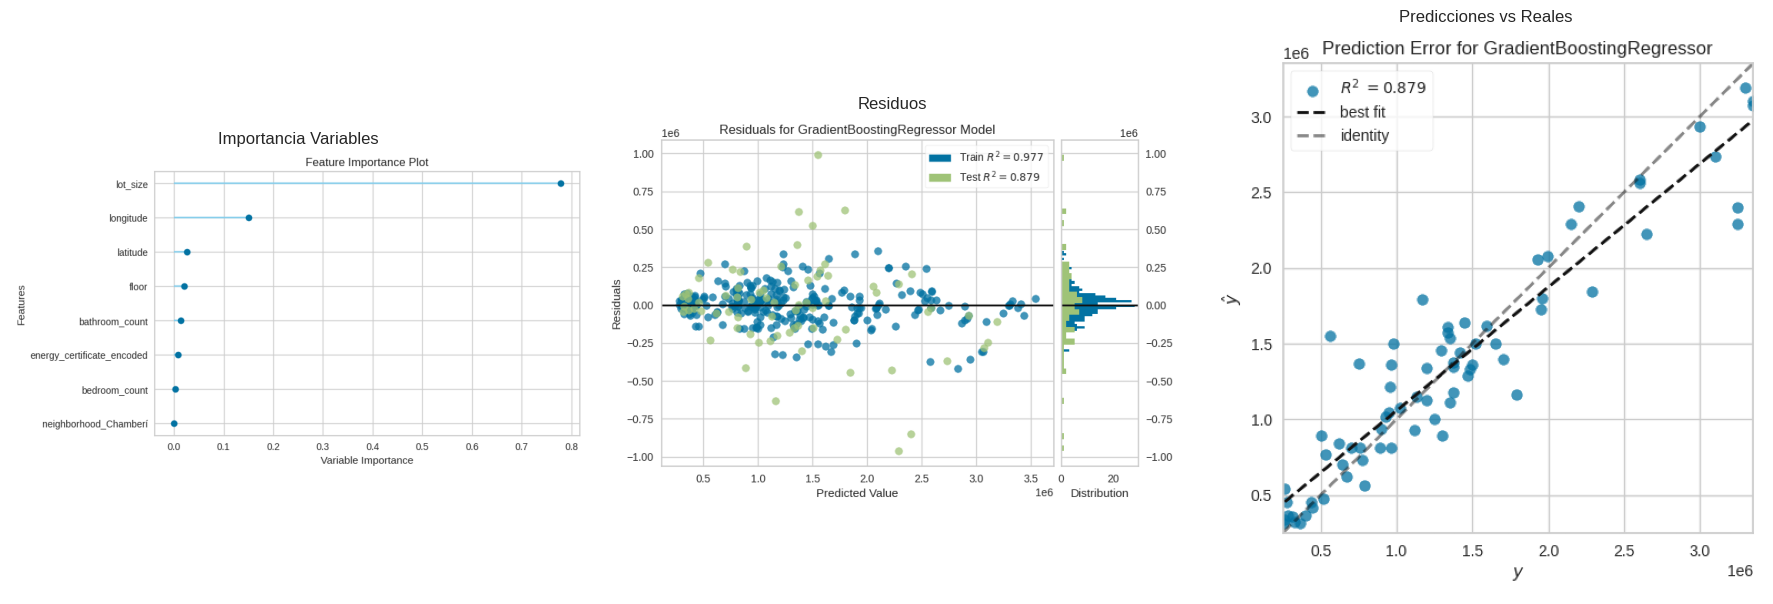


================= Análisis para CENTRO =================
----- Info preliminar -----
Nuḿero de datos:
446

Precio promedio: 1639.70 k€
Precio mínimo: 220.00 k€
Precio máximo: 9000.00 k€

Promedio de metros cuadrados: 280.46 m²
Promedio de baños: 3.28
Promedio de habitaciones: 3.72

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 12

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 18 valores atípicos
 - bedroom_count: 12 valores atípicos
 - floor: 12 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 52 valores atípicos
 - exterior: 48 valores atípicos
 - ascensor: 57 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 356107.37
Error porcentual sobre precio promedio: 23.82%

Visualizaciones del modelo:


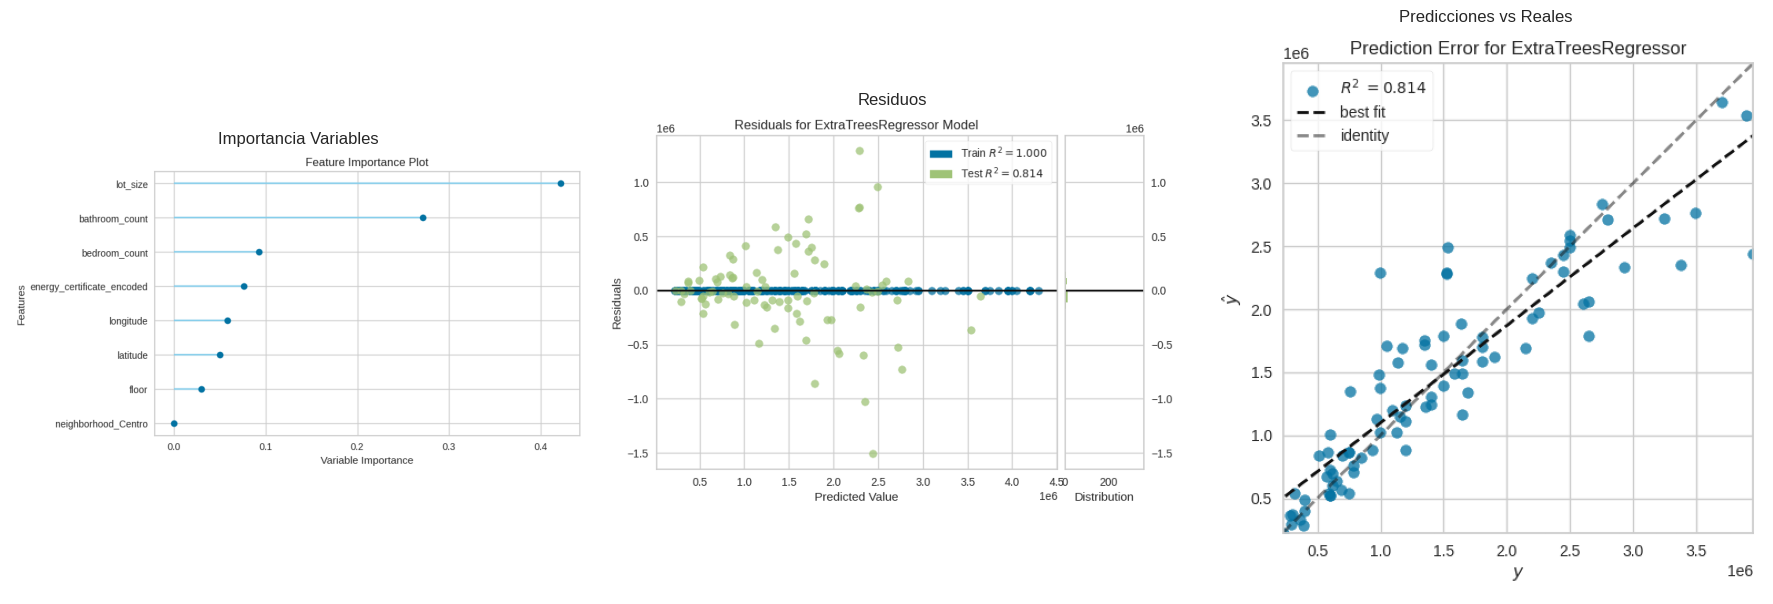


================= Análisis para ARGANZUELA =================
----- Info preliminar -----
Nuḿero de datos:
194

Precio promedio: 499.86 k€
Precio mínimo: 85.40 k€
Precio máximo: 1450.00 k€

Promedio de metros cuadrados: 87.32 m²
Promedio de baños: 1.44
Promedio de habitaciones: 2.45

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 6

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 0 valores atípicos
 - floor: 0 valores atípicos
 - latitude: 1 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 0 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 22 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 69119.66
Error porcentual sobre precio promedio: 14.53%

Visualizaciones del modelo:


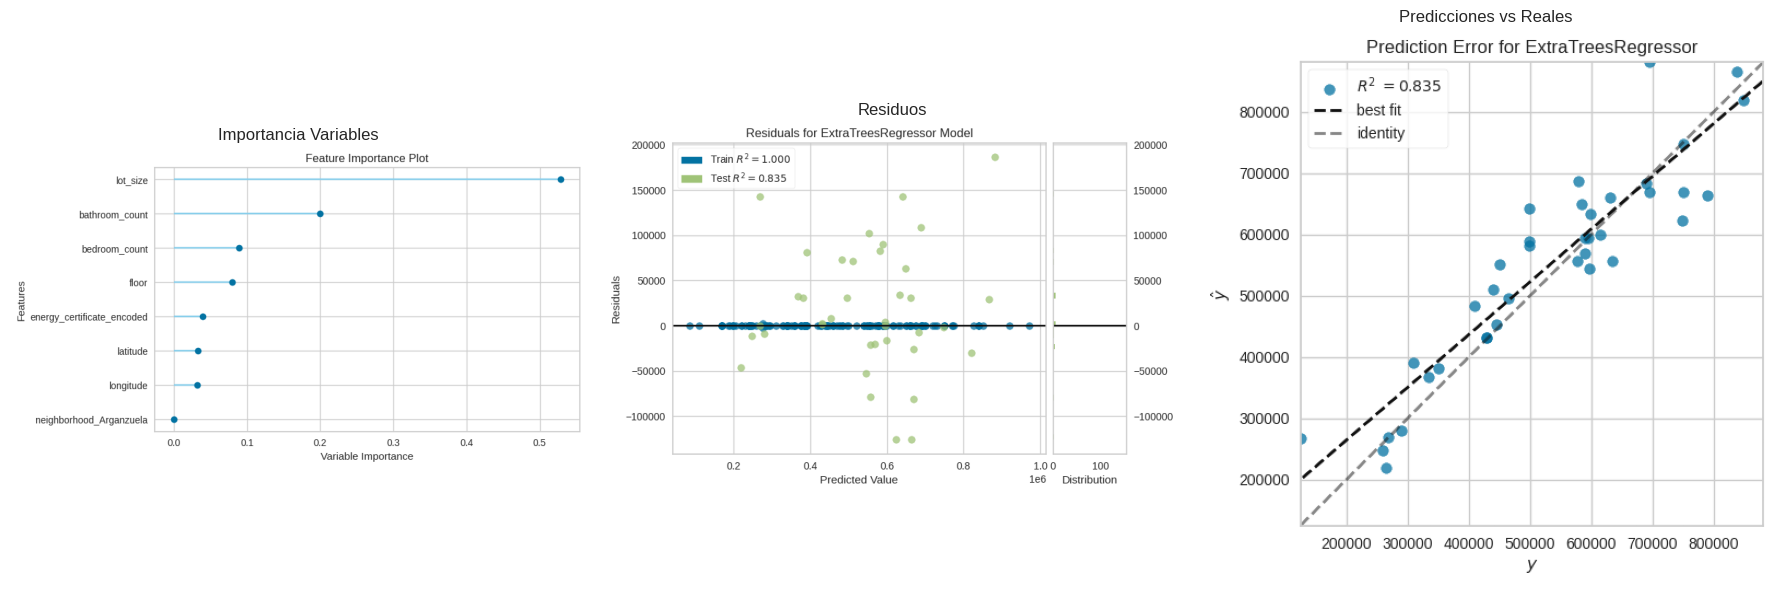


================= Análisis para RETIRO =================
----- Info preliminar -----
Nuḿero de datos:
200

Precio promedio: 1204.72 k€
Precio mínimo: 260.00 k€
Precio máximo: 4800.00 k€

Promedio de metros cuadrados: 135.07 m²
Promedio de baños: 2.12
Promedio de habitaciones: 2.83

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 28

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 7 valores atípicos
 - bedroom_count: 9 valores atípicos
 - floor: 1 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 6 valores atípicos
 - lot_size: 9 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 12 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 174490.98
Error porcentual sobre precio promedio: 19.05%

Visualizaciones del modelo:


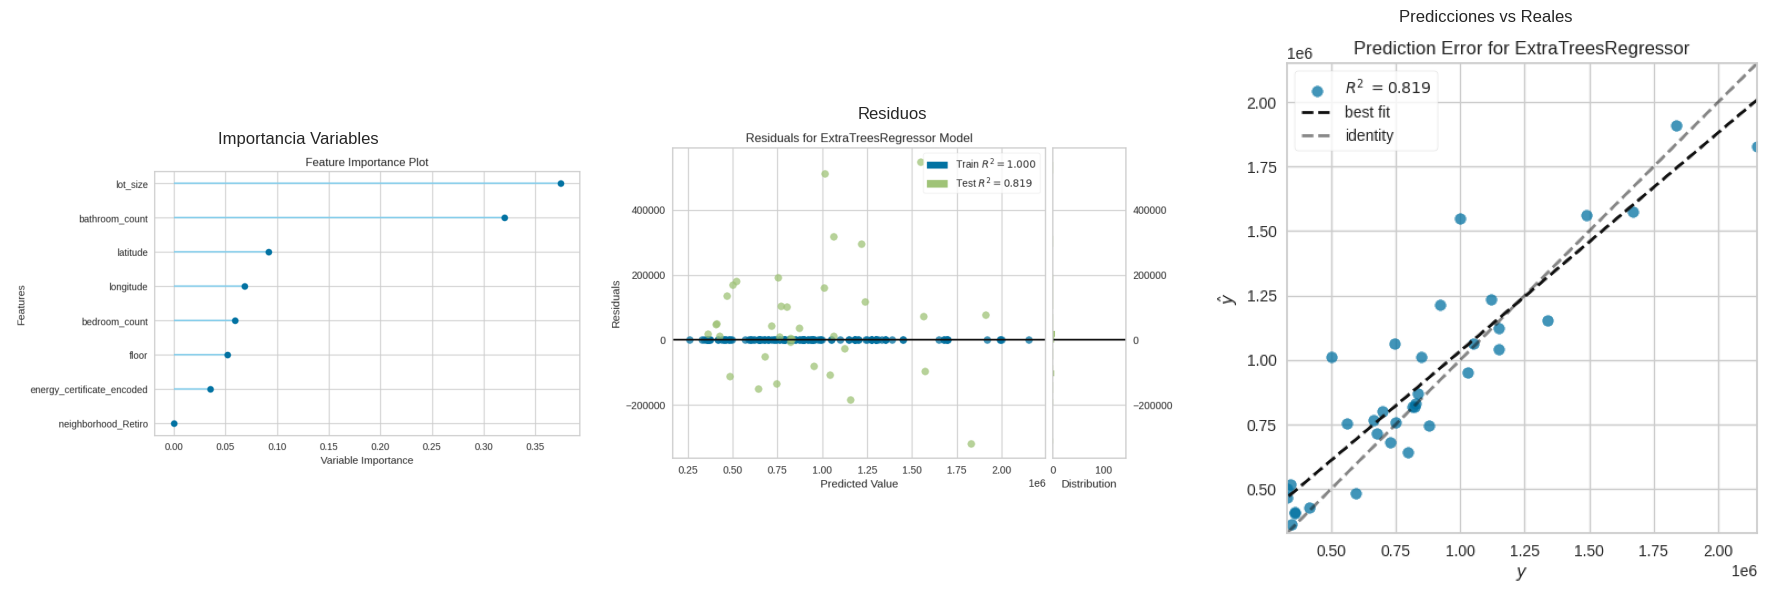

In [ ]:
# Suponiendo que ya tienes estas funciones definidas:
# info_inicial, eliminar_outliers, transformar_variables, mejor_modelo_pycaret, visualizaciones_modelo

neighborhood_dict = {
    1: 'chamberi',
    2: 'centro',
    3: 'arganzuela',
    4: 'retiro'
}

features = ['bathroom_count',
 'bedroom_count',
 'energy_certificate_encoded',
 'floor',
 'neighborhood',
 'lot_size', 'longitude','latitude']

# Crear una lista para almacenar los DataFrames procesados de cada barrio
df_procesados = []

for codigo, nombre in neighborhood_dict.items():
    print(f"\n================= Análisis para {nombre.upper()} =================")

    # 1. Subset del dataset original
    print('----- Info preliminar -----')
    df_barrio = df[df['neighborhood'] == codigo].copy()

    # 2. Info inicial
    info_inicial(df_barrio)

    # 3. Eliminar outliers
    df_barrio = eliminar_outliers(df_barrio)

    # 4. Transformaciones
    df_barrio = transformar_variables(df_barrio)

    # Agregar el DataFrame procesado a la lista
    df_procesados.append(df_barrio)

    # 5. Modelo con PyCaret
    modelo = mejor_modelo_pycaret(df_barrio, features)

    # 6. Visualizaciones
    visualizaciones_modelo(df_barrio, modelo)



================= Análisis para CHAMBERI =================
----- Info preliminar -----
Nuḿero de datos:
392

Precio promedio: 1576.01 k€
Precio mínimo: 250.00 k€
Precio máximo: 7250.00 k€

Promedio de metros cuadrados: 168.65 m²
Promedio de baños: 2.51
Promedio de habitaciones: 3.05

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 25

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 1 valores atípicos
 - floor: 3 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 10 valores atípicos
 - exterior: 70 valores atípicos
 - ascensor: 22 valores atípicos
 - dist_metro_m: 0 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Gradient Boosting Regressor
RMSE: 259581.25
Error porcentual sobre precio promedio: 19.52%

Visualizaciones del modelo:


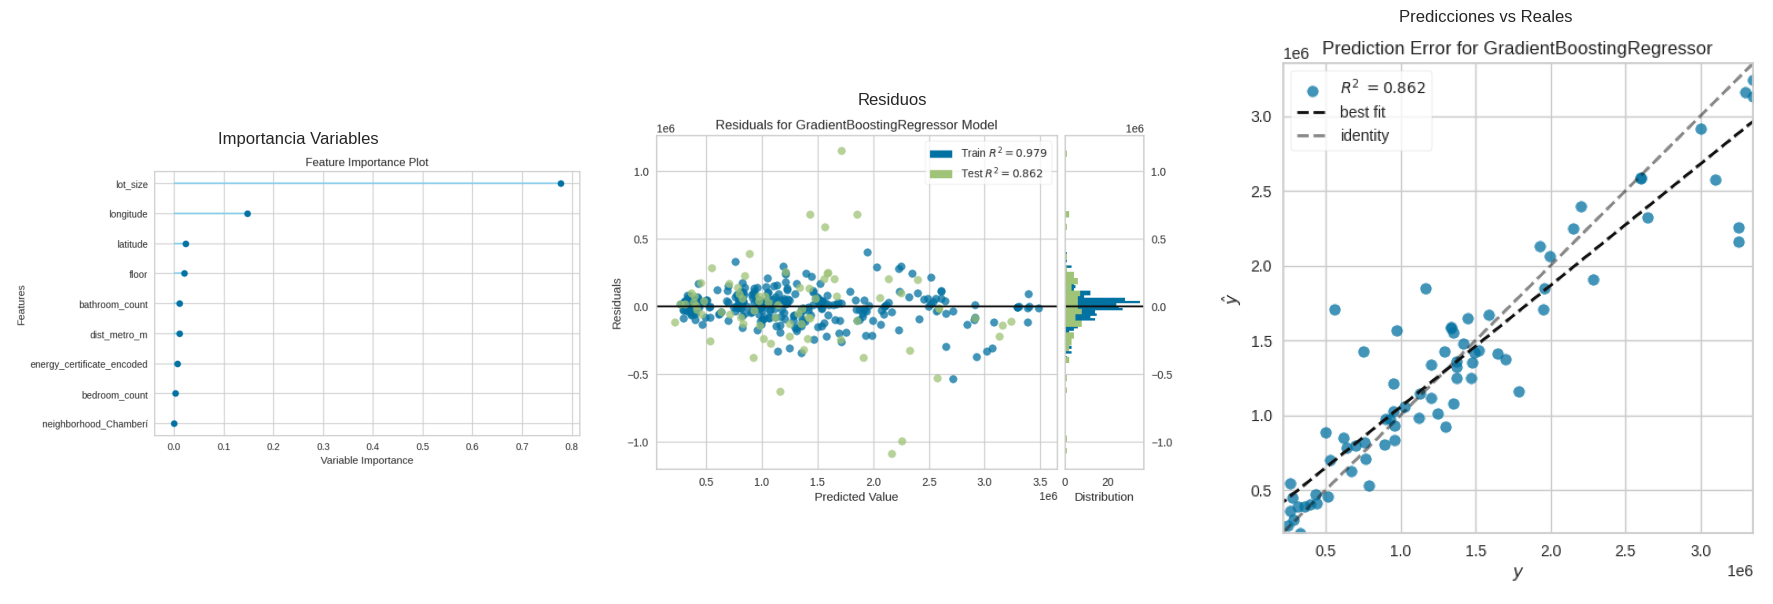


================= Análisis para CENTRO =================
----- Info preliminar -----
Nuḿero de datos:
446

Precio promedio: 1639.70 k€
Precio mínimo: 220.00 k€
Precio máximo: 9000.00 k€

Promedio de metros cuadrados: 280.46 m²
Promedio de baños: 3.28
Promedio de habitaciones: 3.72

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 12

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 18 valores atípicos
 - bedroom_count: 12 valores atípicos
 - floor: 12 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 52 valores atípicos
 - exterior: 48 valores atípicos
 - ascensor: 57 valores atípicos
 - dist_metro_m: 22 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 355125.24
Error porcentual sobre precio promedio: 23.75%

Visualizaciones del modelo:


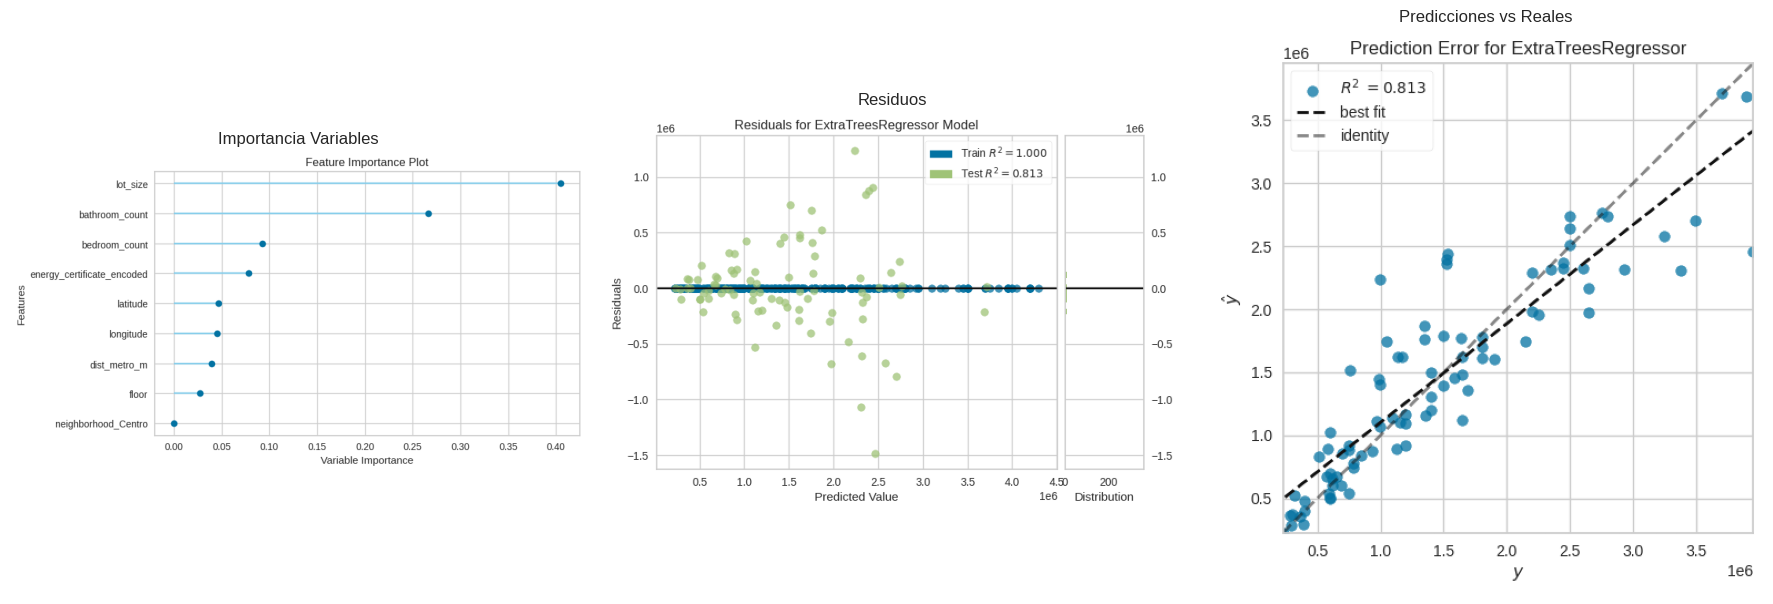


================= Análisis para ARGANZUELA =================
----- Info preliminar -----
Nuḿero de datos:
194

Precio promedio: 499.86 k€
Precio mínimo: 85.40 k€
Precio máximo: 1450.00 k€

Promedio de metros cuadrados: 87.32 m²
Promedio de baños: 1.44
Promedio de habitaciones: 2.45

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 6

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 0 valores atípicos
 - floor: 0 valores atípicos
 - latitude: 1 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 0 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 22 valores atípicos
 - dist_metro_m: 0 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 68177.29
Error porcentual sobre precio promedio: 14.33%

Visualizaciones del modelo:


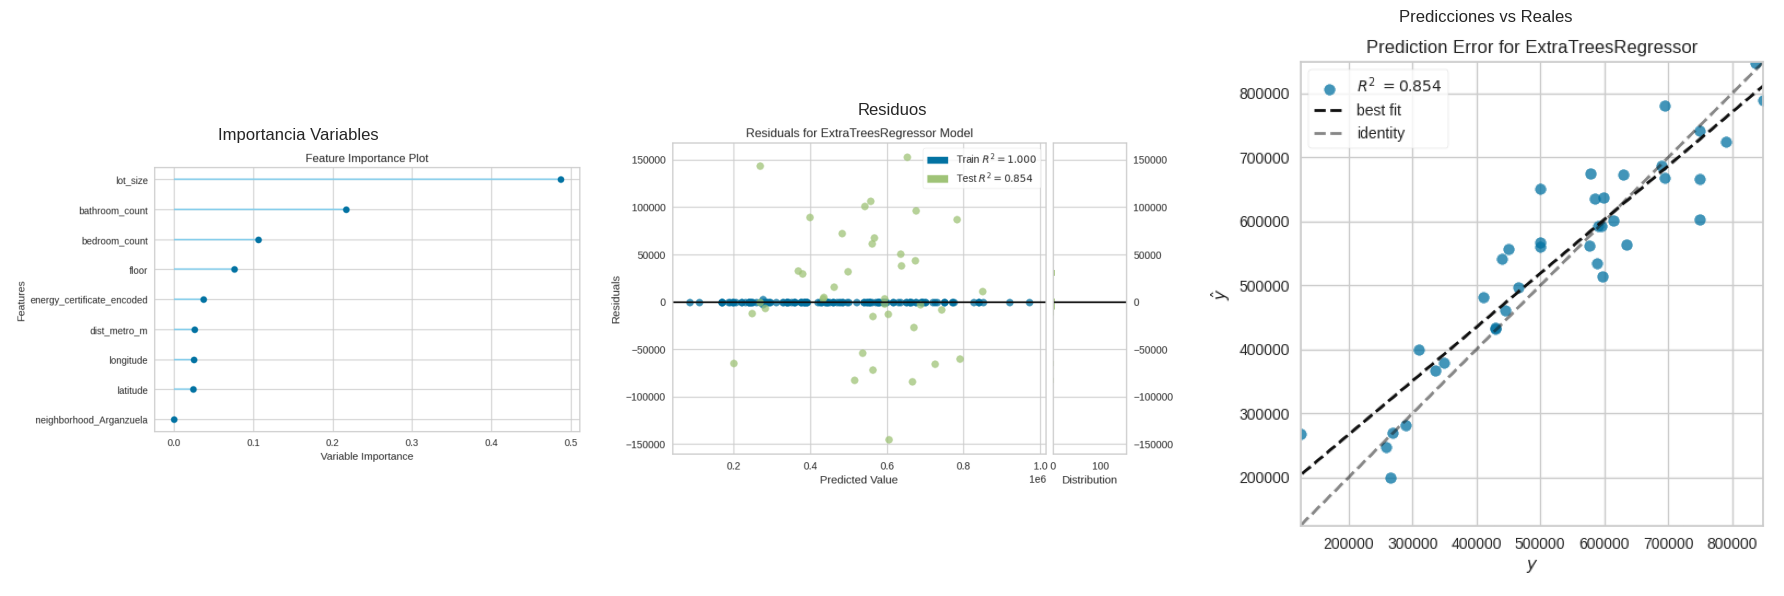


================= Análisis para RETIRO =================
----- Info preliminar -----
Nuḿero de datos:
200

Precio promedio: 1204.72 k€
Precio mínimo: 260.00 k€
Precio máximo: 4800.00 k€

Promedio de metros cuadrados: 135.07 m²
Promedio de baños: 2.12
Promedio de habitaciones: 2.83

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 28

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 7 valores atípicos
 - bedroom_count: 9 valores atípicos
 - floor: 1 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 6 valores atípicos
 - lot_size: 9 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 12 valores atípicos
 - dist_metro_m: 2 valores atípicos
---- variables transformadas correctamente-------

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 180036.12
Error porcentual sobre precio promedio: 19.65%

Visualizaciones del modelo:


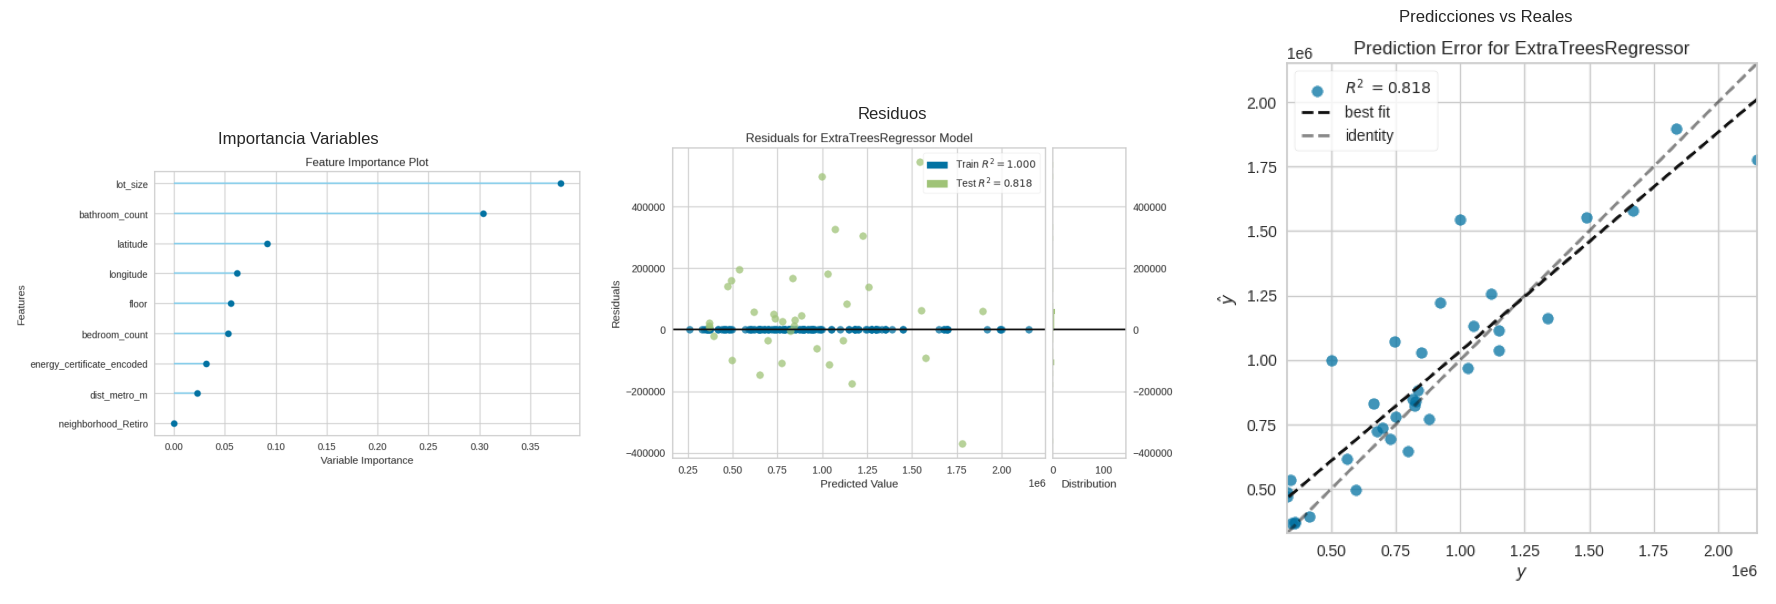

In [ ]:

features = ['bathroom_count',
 'bedroom_count',
 'energy_certificate_encoded',
 'floor',
 'neighborhood',
 'lot_size', 'longitude','latitude','dist_metro_m']

# Crear una lista para almacenar los DataFrames procesados de cada barrio
df_procesados = []

for codigo, nombre in neighborhood_dict.items():
    print(f"\n================= Análisis para {nombre.upper()} =================")

    # 1. Subset del dataset original
    print('----- Info preliminar -----')
    df_barrio = df_metro[df_metro['neighborhood'] == codigo].copy()

    # 2. Info inicial
    info_inicial(df_barrio)

    # 3. Eliminar outliers
    df_barrio = eliminar_outliers(df_barrio)

    # 4. Transformaciones
    df_barrio = transformar_variables(df_barrio)

    # Agregar el DataFrame procesado a la lista
    df_procesados.append(df_barrio)

    # 5. Modelo con PyCaret
    modelo = mejor_modelo_pycaret(df_barrio, features)

    # 6. Visualizaciones
    visualizaciones_modelo(df_barrio, modelo)